In [ ]:
# Connect to Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# do all of the imports
import pandas as pd
import numpy as np
import re
import joblib
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras import layers

import matplotlib.pyplot as plt
# import string
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# load in the ETL file
df = pd.read_csv("gdrive/MyDrive/Colab Notebooks/Final-Project/Resource/IMDB_eliot3.csv")
df.head()

,Unnamed: 0,index,movie_id,movie_name,genre,plot
0,0,76,tt0006864,Intolerance,"drama, history",intolerance story poor young woman separated p...
1,1,506,tt0017136,Metropolis,"drama, sci-fi",metropolis futuristic city sharply divided wor...
2,2,566,tt0018037,Il cantante di jazz,"drama, music, musical",il cantante di jazz son jewish cantor must def...
3,3,628,tt0018773,Il circo,"comedy, romance",il circo tramp finds work girl dreams circus
4,4,714,tt0019777,The Cocoanuts,"comedy, musical",cocoanuts florida land boom


In [ ]:
# drop unwanted leftover columns and split tags in genre column
df = df.drop(["Unnamed: 0", "index"], axis=1)
df["genre"] = df["genre"].str.replace(' ', '')
df["genre"] = df["genre"].str.split(",")
df.head()

,movie_id,movie_name,genre,plot
0,tt0006864,Intolerance,"[drama, history]",intolerance story poor young woman separated p...
1,tt0017136,Metropolis,"[drama, sci-fi]",metropolis futuristic city sharply divided wor...
2,tt0018037,Il cantante di jazz,"[drama, music, musical]",il cantante di jazz son jewish cantor must def...
3,tt0018773,Il circo,"[comedy, romance]",il circo tramp finds work girl dreams circus
4,tt0019777,The Cocoanuts,"[comedy, musical]",cocoanuts florida land boom


In [ ]:
# get all genre tags in a list
all_genres = sum(df["genre"],[])
len(set(all_genres))

21

In [ ]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

# create bar chart for genre tag counts
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

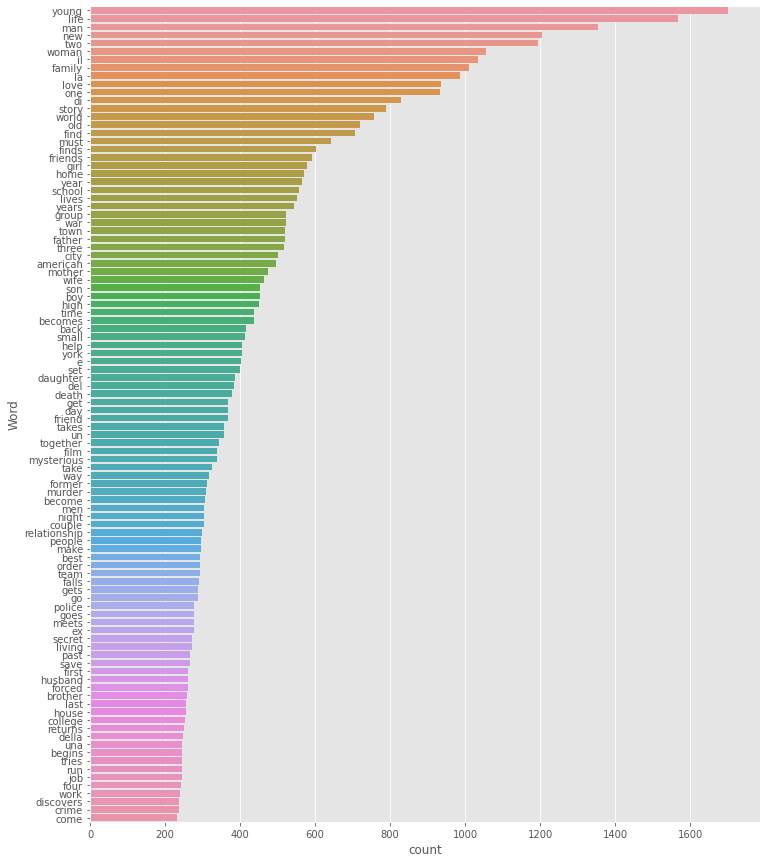

In [ ]:
# create bar chart for top 100 most frequent word counts in plot column
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(df['plot'], 100)

In [ ]:
# transform output using multilabelbinarizer
# will transform y into array of arrays with binary info

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genre'])
y = multilabel_binarizer.transform(df['genre'])

# list all labels
list(multilabel_binarizer.classes_)

['action',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'romance',
 'sci-fi',
 'sport',
 'thriller',
 'war',
 'western']

In [ ]:
# split the data with train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["plot"], y, test_size=0.2, random_state=42)

# define vectorizer
# using TF-IDF which assign a score to each feature
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [ ]:
# run logistic regression
lr = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs")
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(X_train_tfidf, y_train)
score = clf.score(X_test_tfidf, y_test)

print("Accuracy:", score)
print(f"Training Data Score: {clf.score(X_train_tfidf, y_train)}")
print(f"Testing Data Score: {clf.score(X_test_tfidf, y_test)}")

Accuracy: 0.14495481927710843
Training Data Score: 0.2813706109385296
Testing Data Score: 0.14495481927710843


In [ ]:
# hyperparameter tuning
param_grid = {'estimator__C': [10, 50, 100],
              'estimator__max_iter': [200, 500, 1000]}
grid = GridSearchCV(clf, param_grid, verbose=3)

# Train the model with GridSearch
grid.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] estimator__C=10, estimator__max_iter=200 ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  estimator__C=10, estimator__max_iter=200, score=0.135, total=  26.8s
[CV] estimator__C=10, estimator__max_iter=200 ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.8s remaining:    0.0s


[CV]  estimator__C=10, estimator__max_iter=200, score=0.139, total=  25.1s
[CV] estimator__C=10, estimator__max_iter=200 ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.9s remaining:    0.0s


[CV]  estimator__C=10, estimator__max_iter=200, score=0.139, total=  27.3s
[CV] estimator__C=10, estimator__max_iter=200 ........................
[CV]  estimator__C=10, estimator__max_iter=200, score=0.139, total=  28.0s
[CV] estimator__C=10, estimator__max_iter=200 ........................
[CV]  estimator__C=10, estimator__max_iter=200, score=0.156, total=  26.5s
[CV] estimator__C=10, estimator__max_iter=500 ........................
[CV]  estimator__C=10, estimator__max_iter=500, score=0.135, total=  26.4s
[CV] estimator__C=10, estimator__max_iter=500 ........................
[CV]  estimator__C=10, estimator__max_iter=500, score=0.139, total=  25.7s
[CV] estimator__C=10, estimator__max_iter=500 ........................
[CV]  estimator__C=10, estimator__max_iter=500, score=0.139, total=  26.7s
[CV] estimator__C=10, estimator__max_iter=500 ........................
[CV]  estimator__C=10, estimator__max_iter=500, score=0.139, total=  28.3s
[CV] estimator__C=10, estimator__max_iter=500 ...

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV]  estimator__C=50, estimator__max_iter=200, score=0.120, total=  36.1s
[CV] estimator__C=50, estimator__max_iter=200 ........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV]  estimator__C=50, estimator__max_iter=200, score=0.129, total=  36.3s
[CV] estimator__C=50, estimator__max_iter=200 ........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV]  estimator__C=50, estimator__max_iter=200, score=0.128, total=  33.9s
[CV] estimator__C=50, estimator__max_iter=200 ........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV]  estimator__C=50, estimator__max_iter=200, score=0.119, total=  36.2s
[CV] estimator__C=50, estimator__max_iter=200 ........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV]  estimator__C=50, estimator__max_iter=200, score=0.142, total=  36.0s
[CV] estimator__C=50, estimator__max_iter=500 ........................
[CV]  estimator__C=50, estimator__max_iter=500, score=0.120, total=  37.5s
[CV] estimator__C=50, estimator__max_iter=500 ........................
[CV]  estimator__C=50, estimator__max_iter=500, score=0.129, total=  39.0s
[CV] estimator__C=50, estimator__max_iter=500 ........................
[CV]  estimator__C=50, estimator__max_iter=500, score=0.128, total=  36.2s
[CV] estimator__C=50, estimator__max_iter=500 ........................
[CV]  estimator__C=50, estimator__max_iter=500, score=0.119, total=  38.4s
[CV] estimator__C=50, estimator__max_iter=500 ........................
[CV]  estimator__C=50, estimator__max_iter=500, score=0.142, total=  37.7s
[CV] estimator__C=50, estimator__max_iter=1000 .......................
[CV]  estimator__C=50, estimator__max_iter=1000, score=0.120, total=  37.3s
[CV] estimator__C=50, estimator__max_iter=1000 .

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV]  estimator__C=100, estimator__max_iter=200, score=0.117, total=  36.2s
[CV] estimator__C=100, estimator__max_iter=200 .......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV]  estimator__C=100, estimator__max_iter=200, score=0.128, total=  37.9s
[CV] estimator__C=100, estimator__max_iter=200 .......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV]  estimator__C=100, estimator__max_iter=200, score=0.125, total=  38.4s
[CV] estimator__C=100, estimator__max_iter=200 .......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV]  estimator__C=100, estimator__max_iter=200, score=0.113, total=  38.6s
[CV] estimator__C=100, estimator__max_iter=200 .......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV]  estimator__C=100, estimator__max_iter=200, score=0.132, total=  38.5s
[CV] estimator__C=100, estimator__max_iter=500 .......................
[CV]  estimator__C=100, estimator__max_iter=500, score=0.117, total=  40.1s
[CV] estimator__C=100, estimator__max_iter=500 .......................
[CV]  estimator__C=100, estimator__max_iter=500, score=0.127, total=  41.9s
[CV] estimator__C=100, estimator__max_iter=500 .......................
[CV]  estimator__C=100, estimator__max_iter=500, score=0.124, total=  43.7s
[CV] estimator__C=100, estimator__max_iter=500 .......................
[CV]  estimator__C=100, estimator__max_iter=500, score=0.112, total=  45.0s
[CV] estimator__C=100, estimator__max_iter=500 .......................
[CV]  estimator__C=100, estimator__max_iter=500, score=0.131, total=  43.1s
[CV] estimator__C=100, estimator__max_iter=1000 ......................
[CV]  estimator__C=100, estimator__max_iter=1000, score=0.117, total=  39.4s
[CV] estimator__C=100, estimator__max_ite

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 26.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=None, error_score=nan,
             estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=1000,
                                                                        multi_class='multinomial',
                                                                        n_jobs=None,
                                                                        penalty='l2',
                                                                        random

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

{'estimator__C': 10, 'estimator__max_iter': 200}
0.14176900409881465


In [ ]:
# make predictions for validation set
y_pred = clf.predict(X_test_tfidf)

# display multi-label prediction
multilabel_binarizer.inverse_transform(y_pred)[:10]

[('comedy', 'horror'),
 ('drama',),
 ('drama',),
 ('crime', 'drama'),
 ('comedy', 'drama'),
 ('comedy', 'drama'),
 ('drama',),
 ('action', 'drama'),
 ('drama',),
 ('drama',)]

In [ ]:
# evaluate performance, default threshold value = 0.5
f1_score(y_test, y_pred, average="micro")

0.5286559249439119

In [ ]:
# predict probabilities
y_pred_prob = clf.predict_proba(X_test_tfidf)

t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

# evaluate performance
f1_score(y_test, y_pred_new, average="micro")

0.6060066380636284

In [ ]:
# functions to display movie names and genre tags
# vectorize and inverse multi-label binarizer
def infer_tags(q):
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [ ]:
for i in range(5): 
  k = X_test.sample(1).index[0] 
  print("Movie: ", df['movie_name'][k], "\nPredicted genre: ", infer_tags(X_test[k])), print("Actual genre: ",df['genre'][k], "\n")

Movie:  A Christmas Horror Story 
Predicted genre:  [('comedy', 'drama', 'horror')]
Actual genre:  ['fantasy', 'horror', 'mystery'] 

Movie:  I nuovi mini ninja 
Predicted genre:  [('drama',)]
Actual genre:  ['action', 'comedy', 'family'] 

Movie:  Fiore di cactus 
Predicted genre:  [('comedy', 'drama')]
Actual genre:  ['comedy', 'romance'] 

Movie:  Horns 
Predicted genre:  [('drama',)]
Actual genre:  ['comedy', 'crime', 'drama'] 

Movie:  Tai ji Cong ling kai shi 
Predicted genre:  [()]
Actual genre:  ['action', 'adventure', 'drama'] 



In [1]:
# print classification report
target_names = multilabel_binarizer.classes_
print(classification_report(y_test, y_pred, target_names=target_names))

NameError: ignored

In [ ]:
# multi-label confusion matrix
multilabel_confusion_matrix(y_test, y_pred)

cm = multilabel_confusion_matrix(y_test, y_pred)

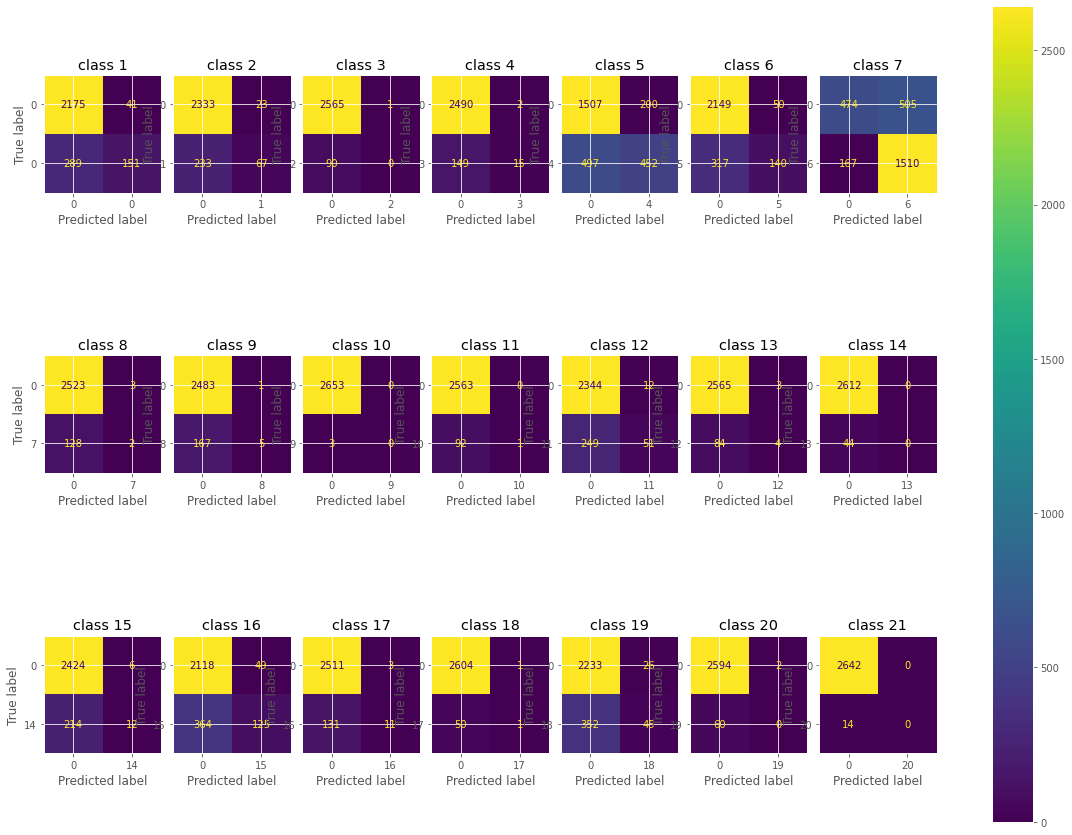

In [ ]:
# plot confusion matrix for each genre label (total of 21)
f, axes = plt.subplots(3, 7, figsize=(20, 15))
axes = axes.ravel()

for i in range(21):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                   y_pred[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i + 1}')
    # if i<10:
    #     disp.ax_.set_xlabel('')
    # if i%5!=0:
    #     disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.grid(b=None)
plt.savefig("gdrive/MyDrive/Colab Notebooks/Final-Project/Images/LR_MultiLabel_ConfusionMatrix_Eliot.jpg", bbox_inches='tight')
plt.show()